In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [2]:

# os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
# os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
# os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')


In [3]:
config_list = [ 'cl_test1']



# config_list = ['cre_setup_2_scale_1_node_info']

# config_list2 = ['global_12cls',\
#                 'local_12cls',\
#                'global_3cls',\
#                'global_4cls',\
#                'global_6cls',\
#                'global_8cls',\
#                'global_2cls',\
#                'local_3cls',\
#                'local_4cls',\
#                'local_6cls',\
#                'local_8cls',\
#                'local_2cls']
# config_list2 = ['local_2cls']


config_list = config_list

In [ ]:

for cfig in config_list:    
    if 2>1:
        os.remove('node_info.csv')

        os.system('cp node_setup/'+cfig+'.csv node_info.csv')


        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count

        replica_count = 0

        for key in node_info_dict['cluster_id'].keys():
            if node_info_dict['cluster_id'][key] ==0:
                replica_count = replica_count + 1


        
        cluster_count = 0
        
        for key in node_info_dict['cluster_id']:
            print(key, node_info_dict['cluster_id'][key])
            if node_info_dict['cluster_id'][key] > cluster_count:
                cluster_count = node_info_dict['cluster_id'][key]
                
        cluster_count = cluster_count + 1
        
        n_clusters = cluster_count

        nclients = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])
            if node_info_dict['ServerOrClientregion'][i] == 1:
                nclients = nclients + 1
        nclients

        clusters_tracked = []
        cluster_regions_tracked = []

        for key in node_info_dict['region']:
            if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
                clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
                cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


        cluster_regions_tracked     

        cluster_regions_tracked, clusters_tracked


        regions = cluster_regions_tracked



        n_regions = len(regions)

        for i,k in enumerate(regions):
            print(i,k)

        for item, idx in enumerate(node_info_dict['region'].keys()):
            print(item, idx, node_info_dict['region'][item])

        lines  = []


        for idx, key in enumerate( node_info_dict['region'].keys()):

            line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
            lines.append(line)

        with open('launch_cloud_instances.sh', 'w') as f:
            for item in lines:
                f.write(str(item) + '\n')


        len(lines), node_info_dict['region'][key].strip()[1:-1]


        def run_command(command):
            subprocess.call(command, shell=True)

        commands = lines

        # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
        with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
            # Submit each command to the executor for parallel execution
            futures = [executor.submit(run_command, command) for command in commands]

            # Wait for all tasks to complete
            concurrent.futures.wait(futures)

    #     time.sleep(30)

        # os.system('sh launch_cloud_instances.sh')

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
                shutil.rmtree(folder)


        instance_type = 'e2-small'


        redirect = '>'

        os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
                  redirect+' all_internal_ips')



        os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_external_ips')

        with open('all_internal_ips') as f:
            ipList = f.read().splitlines()
        ipList = [x for x in ipList if x!='None']

        ipList, len(ipList)

        new_server_only_ips= []
        new_client_only_ips= []



        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                new_server_only_ips = new_server_only_ips + [ipList[i]]
            else:
                new_client_only_ips = new_client_only_ips + [ipList[i]]



        # new_server_only_ips= []
        # new_client_only_ips= []


        # current_region_total = 0
        # for i in range(n_regions):
        #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
        #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

        #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
        #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


        #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

        new_server_only_ips, len(new_server_only_ips)

        new_client_only_ips, len(new_client_only_ips) 

        # ipList = new_server_only_ips + new_client_only_ips

        # ipList, len(ipList)

        nclients = 0
        nservers = 0
        count = 0

        clusterIpMap = {}


        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 0:
                clusterIpMap[nservers] = ipList[count]
                nservers = nservers + 1

            count = count + 1

        nclients = 0
        nservers = 0
        count = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 1:
                print('test: ', 7001+nclients, ipList[count])
                clusterIpMap[7001+nclients] = ipList[count]
                nclients = nclients + 1

            count = count + 1

        clusterIpMap

        # clusterIpMap = {}

        # for i in range(len(ipList)):
        #     clusterIpMap[i] = ipList[i]


        # for i in range(nclients):

        #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

        clusterPortMap1 = {}
        clusterPortMap2 = {}

        for i in range(len(ipList) - nclients):

            clusterPortMap1[i] = str(10000)

        for i in range(len(ipList) - nclients):
            clusterPortMap2[i] = str(20000)

        # clusterPortMap1[7003] = '11400'
        # clusterPortMap2[7003] = '11410'



        temp = 11900

        for i in range(nclients):

            clusterPortMap1[7001+i] = str(10000)
            clusterPortMap2[7001+i] = str(20000)

        clusterPortMap1, clusterPortMap2

        os.system('echo 3108 | sudo -S ./gradlew installDist')

        for i in range(total_count):
            os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

        os.system('echo 3108 | sudo -S ./gradlew clean')

        for key in clusterPortMap1.keys():
            if key>7002:
        #         print(key)
                print()

                for folder in os.listdir('config/'):
                    if os.path.isdir('config/'+folder) and 'keys' in folder:
                        if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                            shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                            shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

                print('----------')
                print()

        for i in range(n_clusters):

            if os.path.exists('config'+str(i)):
                shutil.rmtree('config'+str(i))

            os.mkdir('config'+str(i))
            os.mkdir('config'+str(i)+'/keysRSA')
            os.mkdir('config'+str(i)+'/keysSunEC')
            os.mkdir('config'+str(i)+'/keysECDSA')

        #     print('config'+str(i)+'/keysECDSA')


            shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
            shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
        #     print('config/workloads/', 'config'+str(i)+'/workloads')


            for file in os.listdir('config/keys/'):

                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


            shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
            shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





        clusterIpMap, clusterPortMap1

        def find_key_by_value(dictionary, value):
            for key, val in dictionary.items():
                if val == value:
                    return key
            # If the value is not found, you might want to handle this case accordingly.
            return None


        node_info_dict

        find_key_by_value(node_info_dict['ServerID'], 4)

        for n_cluster in range(n_clusters):

            with open('config'+str(n_cluster)+'/hosts.config','w') as file:

                for key in clusterIpMap:
                    if key < 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                        print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                for key in clusterIpMap:
                    if key >= 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                        print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

                file.close()


        # for n_cluster in range(n_clusters):

        #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

        #         for n_cluster1 in range(n_clusters):

        #             for i_replica in range(replica_count):
        #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
        #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

        #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
        #             print((n_clusters*replica_count) + iter_)

        # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
        #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

        #         for i in range(nclients):
        #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


        #         file.close()


        replica_count

        # for n_cluster in range(n_clusters):
        #     with open('config'+str(n_cluster)+'/system.config','r') as file:
        #         data = file.readlines()
        #         f = int(np.ceil((replica_count-1)/3))
        #         print('f is',f )

        #         for n_line in range(len(data)):
        #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


        #                 data[n_line] = 'system.servers.num = '+str(replica_count)
        #                 print(data[n_line])

        #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.servers.f = '+str(f)
        #                 print(data[n_line])


        #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.initial.view = '
        #                 for iter_view in range(replica_count):
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        #                     print(data[n_line])

        #                 data[n_line] = data[n_line][:-1]
        #                 print(data[n_line])



        #         file.close()

        #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
        #         for line in data:
        #             f.write(f"{line}\n")




        for n_cluster in range(n_clusters):
            with open('config'+str(n_cluster)+'/system.config','r') as file:
                data = file.readlines()


                nservers = 0
                server_id_list = []



                for i in node_info_dict['ServerOrClientregion']:
                    if node_info_dict['ServerOrClientregion'][i] == 0 and \
                    node_info_dict['cluster_id'][i]  == n_cluster:
                        nservers = nservers + 1
                        server_id_list.append(node_info_dict['ServerID'][i])

                f = int(np.ceil((nservers-1)/3))
                print('f is',f )


                for n_line in range(len(data)):
                    if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                        data[n_line] = 'system.servers.num = '+str(nservers)
                        print(data[n_line])

                    if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.servers.f = '+str(f)
                        print(data[n_line])


                    if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.initial.view = '
                        for iter_view in server_id_list:
                            data[n_line] = data[n_line] +str(iter_view)+','
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                            print(data[n_line])

                        data[n_line] = data[n_line][:-1]
                        print(data[n_line])



                file.close()

            with open('config'+str(n_cluster)+'/system.config', 'w') as f:
                for line in data:
                    f.write(f"{line}\n")


        for n_cluster in range(n_clusters):
            for i in range(400):

                for ncls in  range(1):


        #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

        # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push --force origin')
        

        
        
        
        
        
        
        time.sleep(30)

        # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
        # regions = [ 'us-west1-b']


        instance_type = 'e2-small'

        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        f = open('all_external_ips', "r")
        data1 = [line.strip() for line in f.readlines()]

        data1 = [x for x in data1 if x!='None']

        f = open('all_internal_ips', "r")
        data2 = [line.strip() for line in f.readlines()]

        data2 = [x for x in data2 if x!='None']

        data2, len(data2)

        data = []

        skip_instances = 0

        for i in range(skip_instances, len(data1)):
            if data1[i]!='None':
                data.append(data1[i] + '    ' + data2[i])

        data, len(data)

        for index, item in enumerate(data1):
            if 'publicIP' not in node_info_dict.keys():
                node_info_dict['publicIP'] = {}


            node_info_dict['publicIP'][index] = item 


        for index, item in enumerate(data2):
            if 'privateIP' not in node_info_dict.keys():
                node_info_dict['privateIP'] = {}

            node_info_dict['privateIP'][index] = item 



        for index, item in enumerate(data):
            if 'publicAndprivateIP' not in node_info_dict.keys():
                node_info_dict['publicAndprivateIP'] = {}

            node_info_dict['publicAndprivateIP'][index] = item 

        node_info_dict









        # time.sleep(60)

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count





        def getTimeThps(file, flag):

            f = open(file, "r")
            data = f.readlines() 

            times = []
            thputs = []
            for line in data:
                if 'throughput[ops/s]' in line:
                    lineData = (line[13+line.find('max[ops/s])>'):-2])
                    print(lineData)

                    times.append(lineData.split('|')[0])
                    thputs.append(lineData.split('|')[-2])
            if (flag): 
                times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
                thputs.append(0)

            return np.array(times).astype(float), np.array(thputs).astype(float) 

        with open('all_external_ips') as f:
            lines = f.read().splitlines()


        lines = [x for x in lines if x!='None']
        lines, len(lines)

        for ip in lines:
            if ip!='None':
                current = (ip.split('.'))

                print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

        ## Set number of clusters

        nclusters = 0

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config':
                nclusters = nclusters + 1


        print(nclusters)





        nreplicas = int(total_count/nclusters)
        
        nclients = 0
        
        for key in node_info_dict['ServerOrClientregion']:
            if node_info_dict['ServerOrClientregion'][key]==1:
                nclients = nclients + 1
        


        nodeIps = []
        clientIps = []

        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                nodeIps.append(lines[i])
            else:
                clientIps.append(lines[i])


        # nodeIps = lines[:nclusters* nreplicas]


        # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
        no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]


        experiment = 'bft_mc_'+cfig 

        # clientIps = lines[-(nclusters):]



        # clientIps = lines[-nclients:]



        clientIps, no_cluster_yet_nodes



        node_info_dict

        node_info_dict['region'][0].strip()

        ## Functions

        def setup(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

                print(command)
                os.system(command)

        def initialize(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


                os.system(command)


        def git_clone(i):
            ip = lines[i]
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


                os.system(command)

        def git_pull(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


                os.system(command)

        def compile_job(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


                os.system(command)



        def clean_job(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm config/currentView; '
            for iter_ in range(nclusters):
                rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


                os.system(command)


        def clean_all(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


                os.system(command)





        #     if ip!='None' and( ip in no_cluster_yet_nodes):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


        #         os.system(command)        
        # #         print(command)

        def check_node(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


                os.system(command)
        #         print(command)


        def run_basic_client(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                current = (ip.split('.'))


                cmd_arg = str(node_info_dict['clientID'][i])



                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


                os.system(command)


        def kill_java(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


                os.system(command)



        def kill_clients(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and ip in clientIps:
                current = (ip.split('.'))
                command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


                os.system(command)

        def run_server_node_check(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


                print(command)



        # for i in range(len(lines)):
        #     run_server_node_check(i)

        def run_basic_client_check(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                cmd_arg = str(node_info_dict['clientID'][i])


        #         print(i, cmd_arg)

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


                print(command)



        ## First Time Setup

        lines, len(lines)

        # for i in range(10):
        #     setup(i)


        results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
        print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
        print(results)  

        # ## GIT Clone/Pull



        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


        # print(results)  

        # ## Compile Job

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        print(results)  

        # ## CLEAN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        # print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


        def run_server_node(i):
            ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


                os.system(command)



        # for i in node_info_dict['publicIP']:
        #     run_server_node(i)

        ## RUN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  

        ### CHECK NODE RESULT

        # check_node(0)

        # ## Run basic client

        # # time.sleep(20)
        # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
        # print(results)  

        # check_node(0)

        # time.sleep(60)

        # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

        ## Main Job

        # os.system('git add .; git commit -m "test";git push')


        # time.sleep(60)

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')


        #     %%time


        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        # print(results) 





        results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


        results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  


        print('XXXXXXXX Started Servers XXXXXXXXXXXX')

        time.sleep(40)

        check_node(7)



        print('XXXXXXXX Started Clients XXXXXXXXXXXX')

        results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

        time.sleep(80)
#         results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
        time.sleep(120)

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        check_node(0)

        if not os.path.exists('../Experiments/'+experiment):
            os.mkdir('../Experiments/'+experiment)

        os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

                break;



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 



            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
                print(command)
                os.system(command)


        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            print(i)
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)


        node_info_dict

        clientIps




        def getTimesThputs(file):
            f = open(file, "r")
            data = f.readlines() 
            times = []
            thputs = []
            latencies = []
            for line in data:
        #         print(line)
                if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

        #         print(line)
                    times.append(line.split('sec:')[0].strip())
                    thputs.append(line.split(';')[1].split('current')[0].strip())
                
                
                    read_lat = '0'
                    write_lat = '0'
                    
                    if ('READ AverageLatency' in line):
                        
                        print(line)

                        read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()
                        
                        
                    if ('UPDATE AverageLatency' in line):                    
                        
                        write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


                    if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                        latencies.append(line.split('=')[1].split(']')[0].strip())
                    else:
                        read_frac = 0
                        write_frac = 0
                        
                        if float(read_lat) > 0:
                            read_frac = 0.85
                            
                        if float(write_lat) > 0:
                            write_frac = 0.15
                            
#                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))
                        
                        lat = str( (write_frac * float(write_lat) +\
                                    read_frac*float(read_lat))/(write_frac+read_frac)\
                                 )
                        latencies.append(lat)

                    print(line,latencies[-1],thputs[-1],times[-1])

            return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


        times_thputsDict = {}
        times_latsDict = {}


        for ip in clientIps[:1]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

            print(times, thputs)
            for i in range(len(times)):
                times_thputsDict[times[i]] = thputs[i]
                times_latsDict[times[i]] = lats[i]


        for ip in clientIps[1:]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


            for i in range(len(times)):

                if times[i] in times_thputsDict.keys():
                    times_thputsDict[times[i]] += thputs[i]

                if times[i] in times_latsDict.keys():
                    times_latsDict[times[i]] += lats[i]


        times_thputsDict



        PIK = '../Experiments/'+experiment+"/pickle.dat"

        data = [times_thputsDict, times_latsDict]

        with open(PIK, "wb") as f:
            pickle.dump(data, f)

        experiment

        # experiment = 'TestRun2_8_clusters_2'
        # PIK = '../Experiments/'+experiment+"/pickle.dat"

        data2 = []
        
        with open(PIK, "rb") as f:
            data2 =  pickle.load(f)


        dict1 = data2[0]
        dict2 = data2[1]



        times1 = np.array(list(dict1.keys()))
        thputs = np.array(list(dict1.values()))

        times2 = np.array(list(dict2.keys()))
        lats = np.array(list(dict2.values()))

        

        

        times_new = [x for x in range(1+int(times1[-1]))]
        thputs_new = [0 for x in range(1+int(times1[-1]))]

        for idx, t in enumerate(times1):
            thputs_new[int(t)] = thputs[idx]

    

        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times_new[:], thputs_new[:], '-o', label='BfTSmart-MC')


        pl.title(r'Throughput')


        pl.xlabel('Time (s)')
        pl.ylabel('Throughput (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
        pl.show()




        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


        pl.title(r'Latency')


        pl.xlabel('Time (s)')
        pl.ylabel('Latency (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
        pl.show()

        times1, lats

        lats, np.average(lats[-85:-5])/len(clientIps)

        np.sum(thputs),  np.average(thputs[-85:-5])

        thputs

        np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

        # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

        np.sum((thputs[:180]))

        np.sum((thputs[:180]))
        
        
        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

    #             break;




        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')

#     except:
#         os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')
#         continue
    

0 0
1 0
2 0
3 0
4 -1
5 1
6 1
7 1
8 1
9 -1
0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.64  34.159.44.1  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.101  34.159.248.35  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.63  34.159.144.220  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.73  35.246.212.33  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.55  34.89.139.134  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.104  34.141.87.106  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.105  34.89.233.230  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.47  34.159.218.9  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.89  34.141.13.141  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.88  34.159.224.225  RUNNING
test:  7001 10.156.0.73
test:  7002 10.156.0.63


[sudo] password for tejas: 

Starting a Gradle Daemon, 1 incompatible and 1 stopped Daemons could not be reused, use --status for details

> Task :compileJava


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 12s
3 actionable tasks: 3 executed


[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 1s
1 actionable task: 1 executed
test:  0 10.156.0.104 10000 20000 0

test:  1 10.156.0.64 10000 20000 0

test:  2 10.156.0.55 10000 20000 0

test:  3 10.156.0.88 10000 20000 0

test:  4 10.156.0.89 10000 20000 1

test:  5 10.156.0.105 10000 20000 1

test:  6 10.156.0.101 10000 20000 1

test:  7 10.156.0.47 10000 20000 1

test:  7001 10.156.0.73 10000

test:  7002 10.156.0.63 10000

test:  0 10.156.0.104 10000 20000 0

test:  1 10.156.0.64 10000 20000 0

test:  2 10.156.0.55 10000 20000 0

test:  3 10.156.0.88 10000 20000 0

test:  4 10.156.0.89 10000 20000 1

test:  5 10.156.0.105 10000 20000 1

test:  6 10.156.0.101 10000 20000 1

test:  7 10.156.0.47 10000 20000 1

test:  7001 10.156.0.73 10000

test:  7002 10.156.0.63 10000

f is 1
system.servers.num = 4
system.servers.f = 1
system.initial.view = 0,
system.initial.view = 0,1,
system.initial.view = 0,1,2,
system.initial.view = 0,1,2,3,
system.initial.view = 0,1,2,3
f is 1
system.servers.num = 4
sys

fatal: You are not currently on a branch.
To push the history leading to the current (detached HEAD)
state now, use

    git push origin HEAD:<name-of-remote-branch>



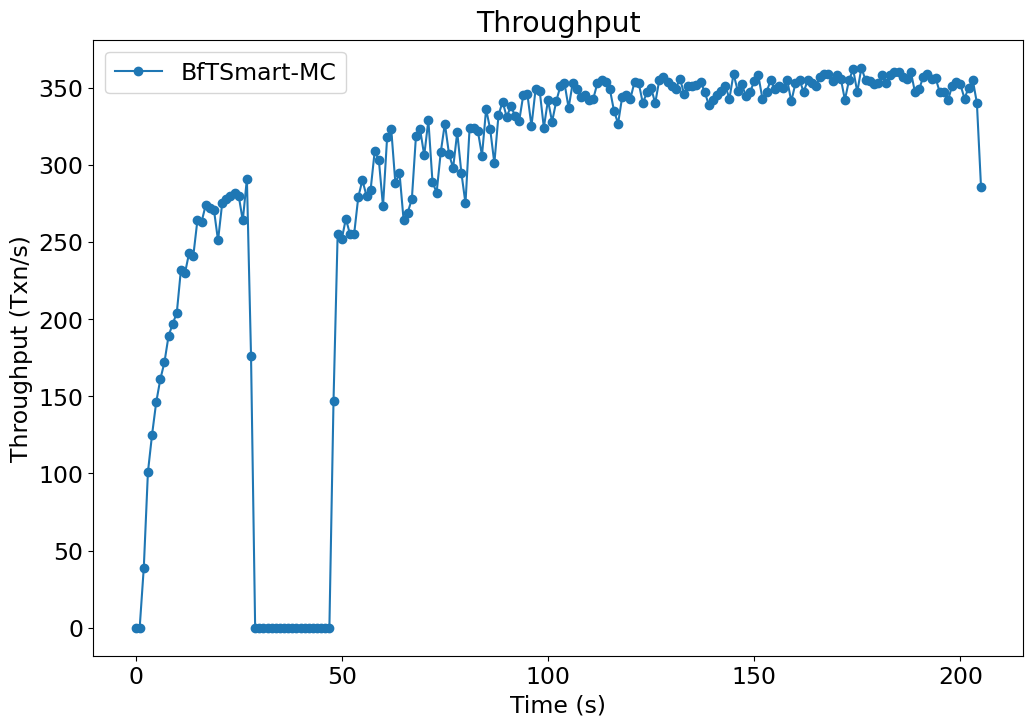

In [5]:


        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times_new[:], thputs_new[:], '-o', label='BfTSmart-MC')


        pl.title(r'Throughput')


        pl.xlabel('Time (s)')
        pl.ylabel('Throughput (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
        pl.show()


In [6]:
# import os
# os.system('git add .; git commit -m "Working with modified ClusterInfo";git push --force origin')


In [7]:
len(times1)

185

In [8]:
np.average(lats)/nclusters

0.00861266843243243

In [9]:
np.average(thputs[60:80])

330.7505

In [10]:
n_clusters

2